In [1]:
import os
import torch
import numpy as np
import cv2
import torch
from torch import nn
from torchvision.ops.boxes import _box_inter_union
from torchvision.ops import generalized_box_iou_loss

In [2]:
!git clone https://github.com/tcotte/CircleDetection.git

Cloning into 'CircleDetection'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 29 (delta 6), reused 24 (delta 5), pack-reused 0
Unpacking objects: 100% (29/29), 220.11 KiB | 8.80 MiB/s, done.


In [3]:
os.makedirs(os.path.join('/content', 'dataset'))
os.makedirs(os.path.join('/content', 'dataset', 'train'))
os.makedirs(os.path.join('/content', 'dataset', 'val'))

In [4]:
!python /content/CircleDetection/dataset_creation/easy_circle.py --path /content/dataset/train --nb_samples 5000
!python /content/CircleDetection/dataset_creation/easy_circle.py --path /content/dataset/val --nb_samples 500

[INFO] Directories creation
[INFO] Dataset creation
100% 4999/4999 [00:01<00:00, 3261.15it/s]
[INFO] Directories creation
[INFO] Dataset creation
100% 499/499 [00:00<00:00, 3373.98it/s]


In [5]:
%cd CircleDetection

/content/CircleDetection


In [11]:
def giou_loss(input_boxes, target_boxes, eps=1e-7):
    """
    Args:
        input_boxes: Tensor of shape (N, 4) or (4,).
        target_boxes: Tensor of shape (N, 4) or (4,).
        eps (float): small number to prevent division by zero
    """
    inter, union = _box_inter_union(input_boxes, target_boxes)
    iou = inter / union

    # area of the smallest enclosing box
    min_box = torch.min(input_boxes, target_boxes)
    max_box = torch.max(input_boxes, target_boxes)
    area_c = (max_box[:, 2] - min_box[:, 0]) * (max_box[:, 3] - min_box[:, 1])

    giou = iou - ((area_c - union) / (area_c + eps))

    loss = 1 - giou

    return loss.sum()


class GIoULoss(torch.nn.Module):
    def __init__(self):
        super(GIoULoss, self).__init__()

    def forward(self, predictions, target):
        return giou_loss(input_boxes=predictions, target_boxes=target, eps=1e-7)

from torchvision.ops import distance_box_iou_loss



class DIoULoss(torch.nn.Module):
    def __init__(self):
      super(DIoULoss, self).__init__()

    def forward(self, predictions, target):
      return distance_box_iou_loss(boxes1=target, boxes2=predictions, reduction="mean")

In [21]:
def fix_bboxes(bboxes):
    for box in bboxes:
        if box[0] > box[2]:
            box[2] = box[0]
        if box[1] > box[3]:
            box[3] = box[1]
    return bboxes


In [49]:
params= resnet.state_dict()
list_layers = list(params.keys())

In [43]:
def print_net_parameters(net):
    for name, para in net.named_parameters():
        print("-"*20)
        print(f"name: {name}")
        print("values: ")
        print(param.requires_grad)

In [47]:
for name, param in resnet.named_parameters():
  if name in list_layers[-5:]:
    print("yes")
    param.requires_grad = True
  else:
    param.requires_grad = False

print_net_parameters(resnet)

yes
yes
--------------------
name: conv1.weight
values: 
True
--------------------
name: bn1.weight
values: 
True
--------------------
name: bn1.bias
values: 
True
--------------------
name: layer1.0.conv1.weight
values: 
True
--------------------
name: layer1.0.bn1.weight
values: 
True
--------------------
name: layer1.0.bn1.bias
values: 
True
--------------------
name: layer1.0.conv2.weight
values: 
True
--------------------
name: layer1.0.bn2.weight
values: 
True
--------------------
name: layer1.0.bn2.bias
values: 
True
--------------------
name: layer1.0.conv3.weight
values: 
True
--------------------
name: layer1.0.bn3.weight
values: 
True
--------------------
name: layer1.0.bn3.bias
values: 
True
--------------------
name: layer1.0.downsample.0.weight
values: 
True
--------------------
name: layer1.0.downsample.1.weight
values: 
True
--------------------
name: layer1.0.downsample.1.bias
values: 
True
--------------------
name: layer1.1.conv1.weight
values: 
True
----------------

In [56]:
import math
import os
import time

import albumentations as A
import matplotlib.pyplot as plt
import torch
from albumentations.pytorch import ToTensorV2
from torch import optim
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader
from torchvision.models import resnet50, resnet18, vgg16
from tqdm import tqdm

from metrics import batch_iou
from model.object_detector import ObjectDetector
from torch_datasets import CustomImageDataset

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False
# specify ImageNet mean and standard deviation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-5
NUM_EPOCHS = 500
BATCH_SIZE = 128
# specify the loss weights
LABELS = 1.0
BBOX = 1.0

model_name = "500_epochs"

CLASSES = ["Circle"]

bbox_format = 'albumentations'
train_transform = A.Compose(
    [
     A.Equalize(mode='cv', by_channels=True, mask=None, p=0.5),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
     A.RandomRotate90(p=0.5),
     # A.Rotate(limit=90, p=0.5, border_mode=0, rotate_method="ellipse"),
     A.CLAHE(p=0.5),
     A.OneOf([
         A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
         A.GridDistortion(p=0.5),
     ], p=0.0),
     A.Normalize(always_apply=True),
     ToTensorV2()],
    bbox_params=A.BboxParams(format=bbox_format, label_fields=['category_ids']),
)

test_transform = A.Compose([
    A.Normalize(always_apply=True),
    ToTensorV2()],
    bbox_params=A.BboxParams(format=bbox_format, label_fields=['category_ids'])
)

train_dataset = CustomImageDataset(
    img_dir=r"/content/dataset/train/img",
    label_dir=r"/content/dataset/train/labels",
    transform=train_transform)

val_dataset = CustomImageDataset(
    img_dir=r"/content/dataset/val/img",
    label_dir=r"/content/dataset/val/labels",
    transform=test_transform)

training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



print("[INFO] total training samples: {}...".format(len(train_dataset)))
print("[INFO] total test samples: {}...".format(len(val_dataset)))
# calculate steps per epoch for training and validation set
trainSteps = math.ceil(len(train_dataset) / BATCH_SIZE)
valSteps = math.ceil(len(val_dataset) / BATCH_SIZE)
# create data loaders
trainLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=os.cpu_count(), pin_memory=PIN_MEMORY)
testLoader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                        num_workers=os.cpu_count(), pin_memory=PIN_MEMORY)

# Network
# load the ResNet50 network
backbone = resnet18(pretrained=False)
# backbone = vgg16(pretrained=False)

# freeze all ResNet50 layers so they will *not* be updated during the
# training process
params= backbone.state_dict()
list_layers = list(params.keys())
for name, param in backbone.named_parameters():
  if name in list_layers[0:]:
    param.requires_grad = True
  else:
    param.requires_grad = False

# create our custom object detector model and flash it to the current
# device
objectDetector = ObjectDetector(backbone, len(CLASSES))
objectDetector = objectDetector.to(DEVICE)
# define our loss functions

classLossFunc = CrossEntropyLoss()

bboxLossFunc = DIoULoss()
# initialize the optimizer, compile the model, and show the model
# summary
opt = optim.Adam(objectDetector.parameters(), lr=INIT_LR)

# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],
      "val_class_acc": [], "train_iou": [], "val_iou": []}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    objectDetector.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    train_iou = 0
    val_iou = 0

    # loop over the training set
    for (images, labels, bboxes, filenames) in trainLoader:
        # send the input to the device
        labels = torch.Tensor(labels)
        # bboxes = torch.stack(bboxes, dim=1)

        bboxes = bboxes.to(torch.float32)
        bboxes = torch.squeeze(bboxes, 1)

        (images, labels, bboxes) = (images.to(DEVICE),
                                    labels.to(DEVICE), bboxes.to(DEVICE))
        # perform a forward pass and calculate the training loss
        opt.zero_grad()
        predictions = objectDetector(images)
        bboxLoss = bboxLossFunc(predictions =predictions[0], target=bboxes)

        totalLoss = BBOX * bboxLoss
        totalLoss = totalLoss.to(torch.float)

        # zero out the gradients, perform the backpropagation step,
        # and update the weights

        totalLoss.backward()
        opt.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        train_iou += batch_iou(a=predictions[0].detach().cpu().numpy(), b=bboxes.cpu().numpy()).sum() / len(bboxes)
        totalTrainLoss += totalLoss
        trainCorrect += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()

    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        objectDetector.eval()
        # loop over the validation set
        for (images, labels, bboxes, _) in testLoader:
            # send the input to the device
            labels = torch.Tensor(labels)
            bboxes = torch.squeeze(bboxes, 1)

            # bboxes = torch.stack(bboxes, dim=1)
            (images, labels, bboxes) = (images.to(DEVICE),
                                        labels.to(DEVICE), bboxes.to(DEVICE))
            # make the predictions and calculate the validation loss
            predictions = objectDetector(images)
            bboxLoss = bboxLossFunc(predictions[0], bboxes)
            totalLoss = BBOX * bboxLoss
            totalValLoss += totalLoss
            # calculate the number of correct predictions
            val_iou += batch_iou(a=predictions[0].detach().cpu().numpy(), b=bboxes.cpu().numpy()).sum() / len(
                bboxes)
            valCorrect += (predictions[1].argmax(1) == labels).type(torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(train_dataset)
    valCorrect = valCorrect / len(val_dataset)
    # update our training history
    H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_class_acc"].append(trainCorrect)
    H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_class_acc"].append(valCorrect)
    H["train_iou"].append(train_iou/trainSteps)
    H["val_iou"].append(val_iou/valSteps)
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.8f}".format(
        avgTrainLoss, train_iou/trainSteps))
    print("Val loss: {:.6f}, Val accuracy: {:.8f}".format(
        avgValLoss, val_iou/valSteps))
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(
        endTime - startTime))

# serialize the model to disk
print("[INFO] saving object detector model...")
# torch.save(objectDetector, MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
torch.save(objectDetector, os.path.join("trained_models", model_name + '.pt'))
# f = open(LE_PATH, "wb")
# f.write(pickle.dumps(le))
# f.close()
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_iou"], label="train_acc_iou")
plt.plot(H["val_iou"], label="val_acc_iou")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# save the training plot
plt.show()


[INFO] total training samples: 4999...
[INFO] total test samples: 499...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AttributeError: ignored

In [14]:
!mkdir "trained_models"

In [52]:
torch.save(objectDetector, os.path.join("trained_models", model_name + '.pt'))

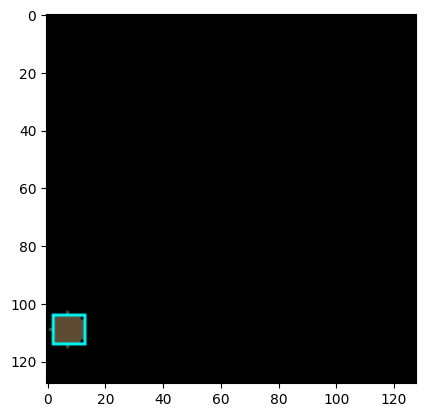

In [55]:
from metrics import get_iou

val_dataset = CustomImageDataset(
    img_dir=r"/content/dataset/val/img",
    label_dir=r"/content/dataset/val/labels", transform=test_transform)


validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

idx = 128

start = time.time()

model = torch.load(r"/content/CircleDetection/trained_models/500_epochs.pt")
model.eval()
model.to('cpu')

avg_iou = 0

with torch.no_grad():

    # print(train_dataset[0][0])
    sample = val_dataset[idx]
    image = sample[0].type(torch.FloatTensor)

    image = torch.unsqueeze(image, 0)

    output = model(image)[0]
    
    # iou = get_iou(output[0][0], sample[2][0])
    # print(sample[-1], iou)
    # avg_iou += iou



    image = cv2.imread(os.path.join(r"/content/dataset/val/img", val_dataset[idx][-1]))

    coords = 128*output[0]
    coords = np.round(coords.numpy())
    coords = [int(x) for x in coords]

    cv2.rectangle(image, (coords[0], coords[1]), (coords[2], coords[3]), (0, 255, 255), 1)
    plt.imshow(image)
    plt.show()
